In [18]:
import netCDF4 as nc

def read_subset(fname):
    with nc.Dataset(fname) as ds:
        qv=ds['qv'][:]
        press=ds['press'][:]
        envNodes=ds['envNodes'][:]
        airTemp=ds['airTemp'][:]
        skTemp=ds['skTemp'][:]
        binNodes=ds['binNodes'][:]
        pwc=ds['pwc'][:]
        sfcEmiss=ds['sfcEmiss'][:]
        dm=ds['dm'][:]
        cldw=ds['cldw'][:]
        sfcBin=ds['sfcBin'][:]
        zCorrected=ds['zCorrected'][:]
        pType=ds['pType'][:]
        lon=ds['lon'][:]
        lat=ds['lat'][:]
        sfcType=ds['sfcType'][:]
        tc=ds['tc'][:]
        tb_sim=ds['simTb'][:]
        scan=ds['scan'][:]
        pRate=ds['pRate'][:]
    return qv,press,envNodes,airTemp,skTemp,binNodes,pwc,sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,sfcType,tc,tb_sim,scan,pRate

import glob

fnames=sorted(glob.glob('subsets/*.nc'))

import numpy as np
nprofs=0
tb_obsL=[]
tb_obsL_m1=[]
tb_obsL_p1=[]
tb_simL=[]
dbinL=[]
dmL=[]
pwcL=[]
pRateL=[]
bin_zdL=[]
pTypeL=[]
zCorrectedL=[]
for f in fnames:
    qv,press,envNodes,airTemp,skTemp,binNodes,pwc,\
        sfcEmiss,dm,cldw,sfcBin,zCorrected,pType,lon,lat,sfcType,tc,tb_sim,scan,pRate=read_subset(f)
    a=np.nonzero(binNodes[:,2]<76)
    dbinL.extend(binNodes[a[0],4]-binNodes[a[0],2])
    for i1 in a[0]:
        if pType[i1]>3:
            continue
        if binNodes[i1,0]>binNodes[i1,2]:
            continue
        if binNodes[i1,4]-binNodes[i1,2]>11:
            n1=int(binNodes[i1,2]-53)
            n2=int(binNodes[i1,2]+11)
            pwcL.append(pwc[i1,n1:n2])
            dmL.append(dm[i1,n1:n2])
            pRateL.append(pRate[i1,n1:n2])
            zCorrectedL.append(zCorrected[i1,n1:n2,0])
            bin_zdL.append(binNodes[i1,2])
            pTypeL.append(pType[i1])
    tb_simL.extend(tb_sim[a[0],6])
    am1=scan[a]-1
    am1[am1<0]=0
    ap1=scan[a]+1
    ap1[ap1>len(tc)-1]=len(tc)-1
    tb_obsL.extend(tc[scan[a],6])
    tb_obsL_m1.extend(tc[am1,6])
    tb_obsL_p1.extend(tc[ap1,6])
    nprofs+=len(a[0])
    

In [19]:
pwcL=np.array(pwcL)
pRateL=np.array(pRateL)
dmL=np.array(dmL)
zCorrectedL=np.array(zCorrectedL)
zCorrectedL[zCorrectedL<0]=0
zCorrectedL[zCorrectedL!=zCorrectedL]=0
dmL[dmL!=dmL]=0

import matplotlib.pyplot as plt
import matplotlib.colors as c
dbinL=np.array(dbinL)
n1=np.nonzero(dbinL>11) 


pRateL=np.array(pRateL)
dmL=np.array(dmL)
pRateL_log = np.log10(1 + pRateL)
pRateL_mean=pRateL_log.mean(axis=0)
pRateL_std=pRateL_log.std(axis=0)
pRateL_log_norm = (pRateL_log - pRateL_mean)/(pRateL_std+1e-3)
dmL_log = np.log10(1 + 30*dmL)
dmL_mean=dmL_log.mean(axis=0)
dmL_std=dmL_log.std(axis=0)
dmL_log_norm = (dmL_log - dmL_mean)/(dmL_std+1e-3)

precip_dm=np.concatenate((pRateL_log_norm[:,np.newaxis,:],dmL_log_norm[:,np.newaxis,:]),axis=1)



In [20]:

import matplotlib.pyplot as plt
import matplotlib.colors as c
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

nc=49

kmeans=KMeans(n_clusters=nc)

kmeans.fit(precip_dm[:,:,-52:].reshape(-1,104))

covL=[]
centroidsL=kmeans.cluster_centers_

for i in range(nc):
    a=np.nonzero(kmeans.labels_==i)
    covL.append(np.cov(precip_dm[a[0],:,-52:].reshape(-1,104).T))

T=np.zeros((nc,nc))
for i,label in enumerate(kmeans.labels_[:-1]):
    label1=kmeans.labels_[i+1]
    T[label,label1]+=1


In [21]:
for i in range(nc):
    T[i,:]=T[i,:]/np.sum(T[i,:])

from numba import jit

def sample_markov(T,init_state,n):
    nstates=T.shape[0]
    state=init_state
    states=np.zeros(n)
    for i in range(n):
        states[i]=state
        state=np.random.choice(nstates,p=T[state,:])
    return states

states=sample_markov(T,10,256)


In [26]:
precipL=[]
from scipy.linalg import cholesky
def sample_gaussian(mu,cov,n):
    L=cholesky(cov)
    nvar=len(mu)
    x=np.random.normal(size=(nvar,n))
    return mu+np.dot(L,x)

def sample_gaussian_1d(mu,cov):
    nvar=len(mu)
    L=cholesky(cov+1e-3*np.eye(nvar))
    x=np.random.normal(size=(nvar,1))
    return (mu+np.dot(L,x)[:,0])

x_last=np.random.normal(size=(104,1))
def sample_gaussian_svd_1d(mu,cov):
    nvar=len(mu)
    U, S, Vt = np.linalg.svd(cov, full_matrices=True)
    x=0.85*np.random.normal(size=(nvar,1))+0.25*x_last
    threshold = 0.01
    S_filtered = np.where(S > threshold, S, 0)
    return (mu+x.T @ np.sqrt(np.diag(S_filtered)) @ Vt)[0,:], x

for istate in states:
    #precip_dm_sample=np.random.multivariate_normal(centroidsL[int(istate)],covL[int(istate)])
    precip_dm_sample,x_last=sample_gaussian_svd_1d(centroidsL[int(istate)],covL[int(istate)])
    precip=precip_dm_sample[:52]*pRateL_std[-52:]+pRateL_mean[-52:]
    precip_nat=10**(precip)-1
    precip_nat[precip_nat<0.01]=0
    precipL.append(precip_nat)

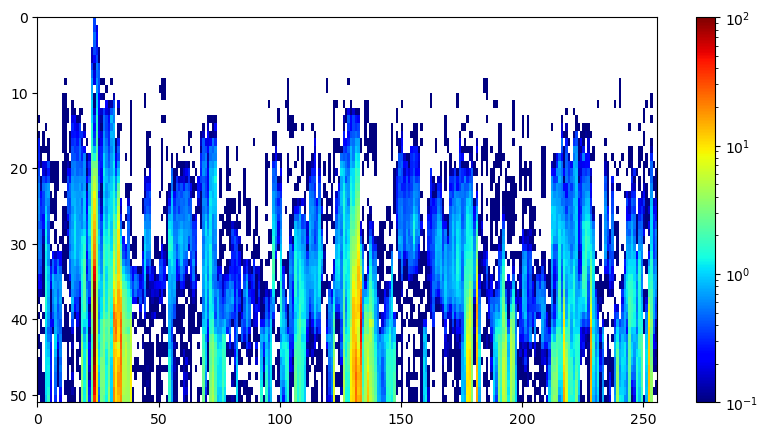

In [27]:
plt.figure(figsize=(10,5))
plt.pcolormesh(np.array(precipL).T,cmap='jet',norm=c.LogNorm(vmin=0.1,vmax=100))
plt.ylim(51,0)
plt.colorbar()

In [58]:
# implement drawing from a multivariate normal distribution using cholesky decomposition


precip_dm1=sample_gaussian_1d(centroidsL[0],covL[0])
print(precip_dm1.shape) 

(104,)
